# Notes on the variables

## Introduction
In this notebook we did research on the features of the data set and had a look at the data preprocessing necessary for our project. Based on this research, we made decisions concerning outlier treatment, imputation of missing values, binning, one-hot encoding, and scaling. Let's first understand the reason to use these processing measures.

**Outlier treatment:**
Data can have mistakes, deriving for multiple reasons. These outliers can have undesirable effects when analysing the data. As these outliers are mostly the result of (human) errors, we want to take these out. Therefore we apply an outlier treatment, namely capping our data set per feature. The cap is set at 3 standard deviations from the mean for every continuous variable (3 standard deviations below and above the mean).

**Imputation of missing values:**
Also known as gap-filling, this methods concerns artificially completing a data set by imputing missing values. Sometimes information is missing from certain instances of a data set. If this information is not all important, we don't simply want to remove the whole instance as there is still information available. What we did for missing values is to make an intelligent guess of the missing information. We decided on a method per feature.

**Binning:**
Binning is important for two reasons:
* it makes computations a lot faster.
* on a conceptual level binning categorizes a continuous variable. This makes it easy for the model to understand that variable. For example, we frequently do binning without realizing: when somebody says an album was released 1967 we automatically think it was released in the 60's and that in itself is a valuable piece of information.

Binning was done for all continuous variables.

**One-hot encoding:**
Also known as label encoding, this method solves the issue of categorical values. Mostly, categorical values do not have a natural distance assigned. As most machine learning methods work with distances (less/greater or equal than), this is an obstacle. By one-hot-encoding, we solve this issue.

**Scaling:**
Some of our machine learning algorithms are based on finding the most 'similar' data point, where similaraity is measured by distances. If the domain of a certain feature is of a different scale than another, the impact of this feature on the distances between the data point will differ as well. For example, suppose we're looking at the weight in kg and the length in m of people. A difference of 0.30 kg we would consider as a minor difference, whereas a difference of 0.30 m, would be considered as a major difference. Still the impact on the distance between two points would be treated the same. Therefore we want to standardise the feature domains.

The rest of this notebook will be take the reader through our findings and methods of preprocessing

## Basic EDA

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.stats import iqr
%pprint #disables pretty printing to see printed lists horizontally
%matplotlib inline
pd.set_option("display.precision",2)
pd.set_option("display.max_rows",30)
pd.set_option("display.max_columns",40)

Pretty printing has been turned OFF


In [2]:
def df_reset():
    global df,target,target_donation_amount
    raw_df = pd.read_csv("Donors_dataset.csv")
    df = raw_df.drop(["FILE_AVG_GIFT","CONTROL_NUMBER"],axis = 1).copy()
    ordered_names = list(df.columns)
    ordered_names.sort()
    df = df[ordered_names]
    #column names to lowercase
    df.columns = df.columns.str.lower()
    df.reset_index(inplace=True)
    

In [3]:
df_reset()
raw_df = pd.read_csv("Donors_dataset.csv")
df.describe()

,index,card_prom_12,donor_age,file_card_gift,frequency_status_97nk,income_group,in_house,last_gift_amt,lifetime_avg_gift_amt,lifetime_card_prom,lifetime_gift_amount,lifetime_gift_count,lifetime_gift_range,lifetime_max_gift_amt,lifetime_min_gift_amt,lifetime_prom,median_home_value,median_household_income,months_since_first_gift,months_since_last_gift,...,mor_hit_rate,number_prom_12,pct_attribute1,pct_attribute2,pct_attribute3,pct_attribute4,pct_owner_occupied,pep_star,per_capita_income,published_phone,recent_avg_card_gift_amt,recent_avg_gift_amt,recent_card_response_count,recent_card_response_prop,recent_response_count,recent_response_prop,recent_star_status,target_b,target_d,wealth_rating
count,19372.00,19372.00,14577.00,19372.00,19372.00,14980.00,19372.00,19372.00,19372.00,19372.00,19372.00,19372.00,19372.00,19372.00,19372.00,19372.00,19372.00,19372.00,19372.00,19372.00,...,19372.00,19372.00,19372.00,19372.00,19372.00,19372.00,19372.00,19372.0,19372.00,19372.0,19372.00,19372.00,19372.00,19372.00,19372.00,19372.00,19372.00,19372.00,4843.00,10562.00
mean,9685.50,5.37,58.92,5.27,1.98,3.91,0.07,16.58,12.86,18.67,104.43,9.98,11.59,19.21,7.62,47.57,1079.87,341.97,69.48,18.19,...,3.36,12.90,1.03,30.57,29.60,32.85,69.70,0.5,15857.33,0.5,11.69,15.37,1.73,0.23,3.04,0.19,0.93,0.25,15.62,5.01
std,5592.36,1.26,16.67,4.61,1.10,1.86,0.26,11.98,8.79,8.56,105.72,8.69,15.12,16.10,7.96,22.95,960.75,164.21,37.57,4.03,...,9.50,4.64,4.92,11.42,15.12,17.84,21.71,0.5,8710.63,0.5,10.83,10.17,1.54,0.19,2.05,0.11,2.55,0.43,12.45,2.82
min,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.36,2.00,15.00,1.00,0.00,5.00,0.00,5.00,0.00,0.00,15.00,4.00,...,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
25%,4842.75,5.00,47.00,2.00,1.00,2.00,0.00,10.00,8.00,11.00,42.00,4.00,5.00,12.00,3.00,28.00,518.00,232.00,33.00,16.00,...,0.00,11.00,0.00,25.00,20.00,21.00,60.00,0.0,10869.00,0.0,5.00,10.00,1.00,0.10,2.00,0.10,0.00,0.00,10.00,3.00
50%,9685.50,6.00,60.00,4.00,2.00,4.00,0.00,15.00,11.20,18.00,79.00,8.00,10.00,16.00,5.00,47.00,747.00,311.00,65.00,18.00,...,0.00,12.00,0.00,31.00,29.00,32.00,76.00,1.0,13816.50,0.0,10.14,14.00,1.00,0.20,3.00,0.17,0.00,0.00,13.00,5.00
75%,14528.25,6.00,73.00,8.00,3.00,5.00,0.00,20.00,15.00,26.00,132.00,14.00,15.00,21.00,10.00,64.00,1227.00,417.00,105.00,20.00,...,3.00,13.00,0.00,37.00,39.00,43.00,85.00,1.0,18308.25,1.0,16.00,20.00,2.00,0.33,4.00,0.25,1.00,0.25,20.00,7.00
max,19371.00,17.00,87.00,41.00,4.00,7.00,1.00,450.00,450.00,56.00,3775.00,95.00,997.00,1000.00,450.00,194.00,6000.00,1500.00,260.00,27.00,...,241.00,64.00,97.00,99.00,99.00,99.00,99.00,1.0,174523.00,1.0,300.00,260.00,9.00,1.00,16.00,1.00,22.00,1.00,200.00,9.00


**LABEL ENCODING:** Used for exploring correlations

In [4]:
def label_encode(df):
    df_reset()
    df.recency_status_96nk = df.recency_status_96nk.map( {'E':0,'L':1,'F':2, 'N':3, 'A':4, 'S':5} ).astype('int64')
    df.frequency_status_97nk = df.frequency_status_97nk.map( {4:'A',3:'B',2:'C', 1:'D'} )
    df['donor_gender'].values[df.donor_gender == 'A'] = 'F'
    df.donor_gender = df.donor_gender.map( {'F': 1, 'M': 0,'U':3} ).astype('int64')
    df.home_owner = df.home_owner.map( {'H': 1, 'U': 0} ).astype('int64')
    df.overlay_source = df.overlay_source.map({'P':1, 'B':2, 'N':3, 'M':4})
    df.urbanicity = df.urbanicity.map({'U':1,'C':2,'S':3,'T':4,'R':5,'?':6})
    df['ses'].values[df.ses == '?'] = 5
    df.ses = df.ses.astype('int64')
    return df
df_label_encoded =label_encode(df)

A matrix with correlations

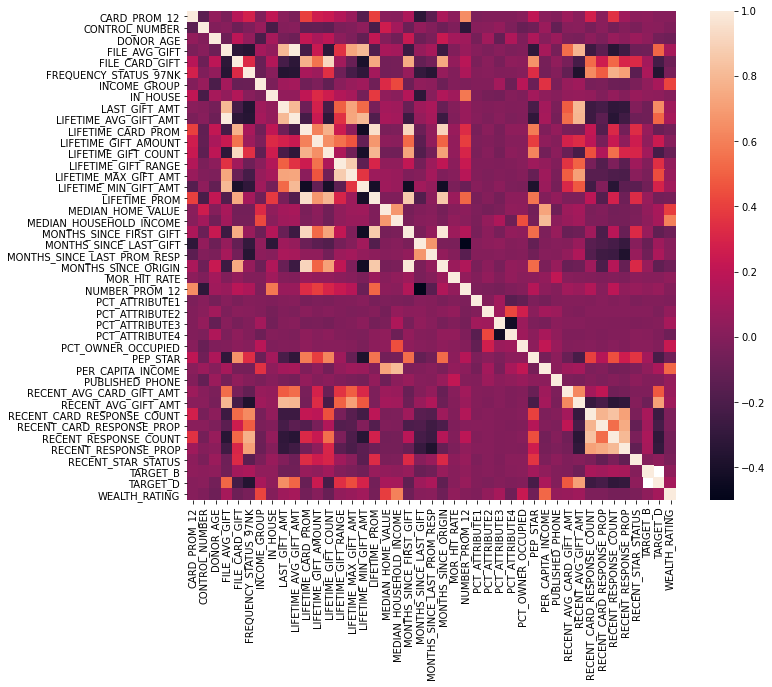

In [5]:
sorted_df = raw_df.reindex(sorted(raw_df.columns), axis=1)
corrmat = sorted_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1., vmin=-.5, square=True);

let's check the data types

In [6]:
types = df.dtypes
types

index              int64
card_prom_12       int64
cluster_code      object
donor_age        float64
donor_gender      object
                  ...   
ses               object
target_b           int64
target_d         float64
urbanicity        object
wealth_rating    float64
Length: 49, dtype: object

#### Cluster_code analysis

In [7]:
unique_vals = df.cluster_code.unique()
sorted(unique_vals)

['.', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '6', '7', '8', '9']

there's a messy '.' that should be addressed, so let's investigate

In [8]:
df[(df.cluster_code =='.')].shape

(454, 49)

This variable highly correlates with urbanicity and ses values. Let's look into that. First let's look at the unique values of cluster code for each urbanicity value.

In [9]:
urban_values = ['U','C','S','T','R','?']
urb_cluster = df[['urbanicity', 'cluster_code']]
grouped = urb_cluster.groupby('urbanicity').groups
print('Urbanicity   :   Unique cluster values')
for key in urban_values:
    print(key, '   :   ', sorted(urb_cluster.cluster_code.iloc[grouped[key]].unique()))


Urbanicity   :   Unique cluster values
U    :    ['1', '10', '2', '3', '4', '5', '6', '7', '8', '9']
C    :    ['22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33']
S    :    ['11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21']
T    :    ['34', '35', '36', '37', '38', '39', '40', '41']
R    :    ['42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53']
?    :    ['.']


clearly, there is straighforward connection between cluster_code and urbanicity. Let's how it relates to ses.

In [10]:
ses_values = ['1', '2' , '3', '4','?']
ses_cluster = df[['ses', 'cluster_code']]
grouped = ses_cluster.groupby('ses').groups
for key in ses_values:
    print(key, ':', sorted(ses_cluster.cluster_code.iloc[grouped[key]].unique()))


1 : ['1', '11', '12', '13', '14', '15', '2', '22', '23', '24', '3', '34', '35', '42']
2 : ['16', '17', '18', '19', '20', '25', '26', '27', '28', '29', '36', '37', '38', '39', '4', '40', '43', '44', '45', '46', '47', '48', '49', '5', '6', '7']
3 : ['21', '30', '31', '32', '33', '41', '50', '51', '52', '53', '8', '9']
4 : ['10']
? : ['.']


The relationship between these two values is not so obvious as with urbanicity. Still, each cluster_code value only corresponds to one value of ses. Also the values of '.' and '?' correspond to missing data in all three fields. This indicates that there might be some problem with those data points so they should not be imputed but given their own value. Even so, both approaches were tried and there was not a significant change in the results. One thing that should be noted is that urbanicity is then the corresponding of a binned version of cluster code, however the same doesn't hold for ses. Also, since there are many of cluster_code for each value of ses/urbanicity, cluster code probably has more information. 


In [11]:
weird_cluster_code_date = df[df.cluster_code == '.']
print(weird_cluster_code_date)

       index  card_prom_12 cluster_code  donor_age donor_gender  \
0          0             5            .       87.0            M   
15        15             6            .       73.0            F   
18        18            10            .        NaN            F   
24        24             5            .       55.0            F   
39        39             6            .        NaN            F   
...      ...           ...          ...        ...          ...   
19355  19355             7            .       80.0            F   
19356  19356             9            .       74.0            M   
19358  19358             5            .        NaN            U   
19370  19370             7            .       78.0            M   
19371  19371             4            .       70.0            M   

       file_card_gift  frequency_status_97nk home_owner  income_group  \
0                   7                      1          H           2.0   
15                 10                      2     

We finally decided to take out all the elements that have cluster code '.' as these points have weird data all over.

Furthermore, no data preprocessing was necessary.

#### Donor gender

In [12]:
df.donor_gender.value_counts()

F    10401
M     7953
U     1017
A        1
Name: donor_gender, dtype: int64

the values A and U are problematic. We impute A with F, and make U into it's own class of number 3.

In [13]:
#Imputation
df['donor_gender'].values[df.donor_gender == 'A'] = 'F'

Let's check everything is ok

In [14]:
df.donor_gender.value_counts()

F    10402
M     7953
U     1017
Name: donor_gender, dtype: int64

now let's put the gender into a binary variable

In [15]:
df.donor_gender = df.donor_gender.map( {'F': 1, 'M': 0, 'U': 3} ).astype('int64')

let's check what are the most correlated variables correlated

In [16]:
df_label_encoded.corr().abs()['donor_gender'].sort_values(ascending=False)[:10]

donor_gender             1.00
home_owner               0.14
published_phone          0.10
overlay_source           0.10
file_card_gift           0.05
mor_hit_rate             0.05
pct_owner_occupied       0.04
lifetime_avg_gift_amt    0.04
months_since_origin      0.04
lifetime_min_gift_amt    0.04
Name: donor_gender, dtype: float64

In [17]:
df.home_owner = df.home_owner.map( {'H': 1, 'U': 0} ).astype('int64')

Text(0.5, 1.0, 'Fraction of home_owners by donor gender')

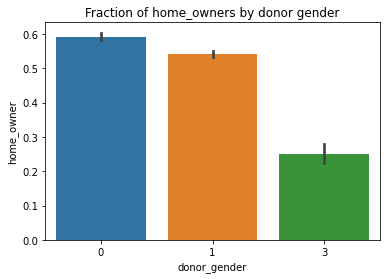

In [18]:
sns.barplot(data= df,x='donor_gender',y='home_owner').set_title('Fraction of home_owners by donor gender')

There is a very low correlation with all the variables and it is barely noticeable in the graph. Probably best to leave the U values as they are. Even so, an approach where the U values were imputed with the mode was also tried but it didn't yield better results

#### Donor age

In [19]:
df_reset()
df.donor_age.isnull()

0        False
1        False
2        False
3         True
4        False
         ...  
19367    False
19368    False
19369     True
19370    False
19371    False
Name: donor_age, Length: 19372, dtype: bool

Donor age has many missing values, we'll start out by imputing with the average, but first let's take a look at the variable

In [20]:
df.donor_age.fillna(value=df.donor_age.mean(),inplace = True)

there are some outliers that should be analyzed

In [21]:
#sorted(df.donor_age)[:100]

probably there are no donors aged less than 5 years old and it is a mistake (pssibly even more, but since it will be binned it doesn't matter). For now, let's replace the values with the mean (should be mean of donors with age above 5 years old. Otherwise you include the "wrong" ages!)

In [22]:
df_label_encoded.corr().abs()['donor_age'].sort_values(ascending=False)[:15]

donor_age                  1.00
months_since_origin        0.24
months_since_first_gift    0.24
lifetime_prom              0.22
lifetime_card_prom         0.22
income_group               0.20
lifetime_gift_count        0.20
file_card_gift             0.19
pct_attribute4             0.15
pep_star                   0.14
lifetime_gift_amount       0.13
in_house                   0.12
lifetime_min_gift_amt      0.12
recency_status_96nk        0.12
pct_attribute3             0.11
Name: donor_age, dtype: float64

In [23]:
pd.cut(df.donor_age,bins=[0,20,30,40,50,70,90])

0        (70, 90]
1        (70, 90]
2        (70, 90]
3        (50, 70]
4        (70, 90]
           ...   
19367    (50, 70]
19368    (70, 90]
19369    (50, 70]
19370    (70, 90]
19371    (50, 70]
Name: donor_age, Length: 19372, dtype: category
Categories (6, interval[int64]): [(0, 20] < (20, 30] < (30, 40] < (40, 50] < (50, 70] < (70, 90]]

In [24]:
df['age_bin'] = pd.cut(df.donor_age,bins=[0,20,30,40,50,70,90])

<AxesSubplot:xlabel='age_bin', ylabel='months_since_origin'>

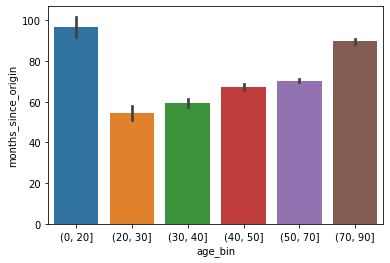

In [25]:
sns.barplot(data=df,x="age_bin",y="months_since_origin")

In [26]:
df.age_bin[df.age_bin==0]

Series([], Name: age_bin, dtype: category
Categories (6, interval[int64]): [(0, 20] < (20, 30] < (30, 40] < (40, 50] < (50, 70] < (70, 90]])

In [27]:
df['age_bin'] = pd.cut(df.donor_age,bins=[0,20,30,40,50,70,80,90])

<AxesSubplot:xlabel='age_bin', ylabel='months_since_origin'>

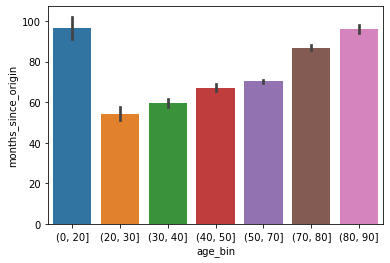

In [28]:
sns.barplot(data=df, x="age_bin",y="months_since_origin")

this variable is nicely correlated with donor_age which means that it can be used in order to impute donor_age. However, there are a few problems with this relationship. First, the fact that there are  so many values bellow 20 in donor_age. In fact, upon further investigation:

In [29]:
list(df.donor_age.sort_values()[:100])

[0.0, 0.0, 2.0, 2.0, 2.0, 4.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 12.0, 14.0, 15.0, 15.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0]

These ages are surely a mistake. Let's look at what the sorted values of months_since_origin are for this variable.

In [30]:
df[['donor_age','months_since_origin']].sort_values(by=['donor_age','months_since_origin'],ascending =[True,False])[:300]

,donor_age,months_since_origin
13698,0.0,137
8967,0.0,77
8992,2.0,137
10008,2.0,137
14789,2.0,77
...,...,...
6168,25.0,29
7750,25.0,29
10029,25.0,29
10072,25.0,29


There are a couple of things to note. The first one is that these low age entries actually have the highest values of months_since_origin in the whole dataset. Given the chart presented above and the clear correlation between the two variables this might indicate that perhaps the mistake is that perhaps the system was not prepared to receive values higher than 100 in the age field so age=0 might actually correspond to 100. Also the maximum value for the age is only 87. However, there are two other points that go against this theory. The first would be that the high months_since_origin values stop abruptly at the age of 18 and the other one being that we have less 0 age values than 2, and less 2 values than 6 and so on. If that number indicated the age in the hundreds, it would be the other way around. Given all this weirdness, the final decision was to transform all the ages bellow 18 to nan and impute everything according to the average donor age value by months_since_origin. 

This is not such an easy task as it may seem. Initially, it was planned to impute the nan values according to the the mean for a given 'months_since_origin' value. This would be that table:

In [31]:
impute_table = df[['months_since_origin','donor_age']][df.donor_age.notnull()].groupby(['months_since_origin']).mean()
impute_table

,donor_age
months_since_origin,
5,55.53
17,55.20
19,55.00
21,58.92
29,56.53
32,58.92
40,58.92
41,55.37
53,57.41


The problem is that there are values of months_since_origin that only have nan in the donor_age field, so it's not possible to have a value of reference for that value:

In [32]:
nan_unique_vals = []
for i in df.months_since_origin[df.donor_age.isnull()].unique():
    if i not in impute_table.index:
        nan_unique_vals.append(i)

print ('list with values of months_since origin that don\'t have any age value:',nan_unique_vals)

list with values of months_since origin that don't have any age value: []


Since the relationship between these variables seem to be linear (excluding those with less than 18 years old), it was decided to impute the above mentioned with a linear regression model.

In [33]:
from sklearn.linear_model import LinearRegression
df.loc[df.donor_age <=18,'donor_age']=np.NaN
X = df.months_since_origin[df.donor_age.notnull()].values.reshape(-1,1)
y = df.donor_age[df.donor_age.notnull()].values.reshape(-1,1)
impute_fit=LinearRegression()
impute_fit = impute_fit.fit(X,y)

In [34]:
for nan_age_index in df.donor_age[df.donor_age.isnull()].index:
    if df.months_since_origin.iloc[nan_age_index] in nan_unique_vals:
        #impute with model in case there is no base reference to impute
        df.at[nan_age_index,'donor_age'] = impute_fit.predict(df.months_since_origin.loc[nan_age_index].reshape(1,-1)).flatten()
    else:
        #impute according to impute_table otherwise
        df.at[nan_age_index,'donor_age'] = impute_table.loc[df.months_since_origin.iloc[nan_age_index]]


#### File card gift

In [35]:
df.file_card_gift.unique()

array([ 7, 12, 16,  3,  6,  8, 14, 13,  2, 10,  4, 23, 11,  1,  9,  5, 22,
       20, 24, 26, 17, 25, 15, 18,  0, 21, 19, 29, 41, 32, 28, 27],
      dtype=int64)

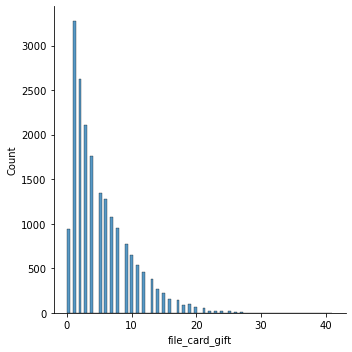

In [36]:
sns.displot(df.file_card_gift)

everything seems in order, let's just convert to float as it is a dollar amount (and other dollar amounts are also in floats)

In [37]:
df.file_card_gift = df.file_card_gift.astype("float64")

#### FREQUENCY_STATUS_97NK

In [38]:
df.frequency_status_97nk.unique()

array([1, 2, 3, 4], dtype=int64)

One-hot encoding was tested but it yielded worse results

#### Home owner

In [39]:
df.home_owner.value_counts()

H    10606
U     8766
Name: home_owner, dtype: int64

there are many unknown values. Let's just turn this into a binary variable for now.

In [40]:
df.home_owner = df.home_owner.map( {'H': 1, 'U': 0} ).astype('int64')

#### Income group

In [41]:
df.income_group.unique()

array([ 2.,  7.,  5.,  6.,  3.,  1.,  4., nan])

In [42]:
df.income_group

0        2.0
1        7.0
2        5.0
3        6.0
4        2.0
        ... 
19367    4.0
19368    5.0
19369    1.0
19370    6.0
19371    5.0
Name: income_group, Length: 19372, dtype: float64

this should be a categorical variable (int) but it's in float

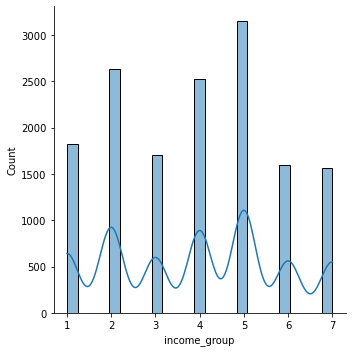

In [43]:
sns.displot(df.income_group,kde=True,)

In [44]:
df.income_group.isnull().sum()

4392

there are many null values. Let's create a different category (value 0) for them for now

In [45]:
df.income_group = df.income_group.fillna(value=0.)

In [46]:
df.income_group = df.income_group.astype('int64')
df.income_group.dtype

dtype('int64')

this column should be a normal distribution even though it doesn't look a lot like one

#### 2nd iteration

In [47]:
df_reset()

Let's check correlations

In [48]:
df_label_encoded.corr().abs()['income_group'].sort_values(ascending=False)[:15]

income_group               1.00
median_household_income    0.43
wealth_rating              0.42
per_capita_income          0.35
ses                        0.33
home_owner                 0.33
median_home_value          0.32
donor_age                  0.20
pct_owner_occupied         0.18
target_d                   0.13
lifetime_gift_count        0.12
lifetime_avg_gift_amt      0.11
pct_attribute3             0.11
file_card_gift             0.10
last_gift_amt              0.10
Name: income_group, dtype: float64

Let's check if the median_household_income values corresponding to nan in income group are of good quality

In [49]:
df[['income_group','median_household_income']][df.income_group.isnull()]

,income_group,median_household_income
10,NaN,179
11,NaN,163
12,NaN,256
13,NaN,219
14,NaN,227
...,...,...
19348,NaN,363
19351,NaN,243
19354,NaN,359
19358,NaN,280


they seem like they are. Let's visualize the relationship between these two variables

<AxesSubplot:xlabel='income_group', ylabel='median_household_income'>

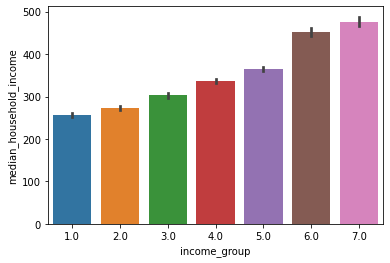

In [50]:
sns.barplot(data=df,x="income_group",y="median_household_income")

It seems like it's perfecto to serve as basis for imputation. Just note that we should impute median_household_income first since there are a handfull of zero values that should be filled first. Also note that the mean for imputation is rounded.

In [51]:
#imputing median_household_income first
#set the 0 to nan
df.loc[df.median_household_income == 0,'median_household_income']=np.NaN
#group by urbanicity and ses, calculate average and use that
df['median_household_income'] = df.groupby(['ses','urbanicity'], sort=False)['median_household_income'].apply(lambda x: x.fillna(x.mean()))

Also, since this a continuous variable, it should be binned.

In [52]:
#binning
df['median_household_bin'] = pd.qcut(df.median_household_income,7,labels=False)
#imputation
df['income_group'] = df.groupby(['median_household_bin'], sort=False)['income_group'].apply(lambda x: x.fillna(x.mean())).copy()
df['income_group'] = df['income_group'].round()
df.drop('median_household_bin',axis=1,inplace=True)

also this variable should be one-hot encoded, to let's convert it to string

In [53]:
df['income_group'] = df['income_group'].astype('str')
df['income_group'].unique()

array(['2.0', '7.0', '5.0', '6.0', '3.0', '1.0', '4.0'], dtype=object)

#### In house

In [54]:
df.in_house.sum()

1418

### Last gift amount AND Lifetime* variables

this section includes 
* **LAST_GIFT_AMT** - amount of the most recent donation from the individual to the charitable organization
* **LIFETIME_AVG_GIFT_AMT** - lifetime average donation (in \\$) from the individual to the charitable organization
* **LIFETIME_CARD_PROM** - total number of card promotions sent to the individual by the charitable organization
* **LIFETIME_GIFT_AMOUNT** - total lifetime donation amount (in \\$) from the individual to the charitable organization
* **LIFETIME_GIFT_COUNT** - total number of donations from the individual to the charitable organization
* **LIFETIME_GIFT_RANGE** - maximum donation amount from the individual minus minimum donation amount from the individual
* **LIFETIME_MAX_GIFT_AMT** - maximum donation amount (in \\$) from the individual to the charitable organization
* **LIFETIME_MIN_GIFT_AMT** - minimum donation amount (in \\$) from the individual to the charitable organization
* **LIFETIME_PROM** - total number of promotions sent to the individual by the charitable organization

#### Binning and outlier treatment

To guarentee that the binning makes sense, a threshold should be employed so that most bins aren't empty because of the outliers. Let's look at the Last_gift_amt column as an example. The distribution goes like this

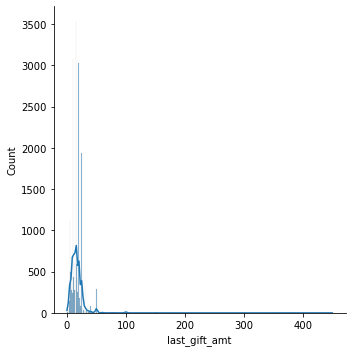

In [55]:
sns.displot(df.last_gift_amt,kde=True,)

For all the above features, outlier treatment and binning was applied. For outlier treatment we decided upon thresholds of 3 standard deviations above and below the average of the feature. For the above example that would be:

In [56]:
upper_threshold = df['last_gift_amt'].mean()+3*df['last_gift_amt'].std()
print(upper_threshold)

52.51687189823505


Which makes a lot of sense!

<b>MEDIAN HOME VALUE</b> - median home value (in 100$) as determined by other input variables

In [57]:
df_reset()

In [58]:
df.median_home_value.isnull().sum()

0

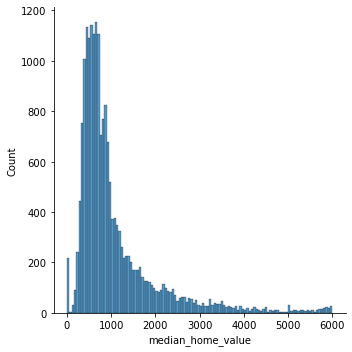

In [59]:
sns.displot(df.median_home_value)

In [60]:
df.median_home_value.value_counts()

0       218
675      68
550      50
575      39
875      39
       ... 
1907      1
4696      1
3922      1
5953      1
2047      1
Name: median_home_value, Length: 3130, dtype: int64

Let's explore the connections with urbanicity and SES

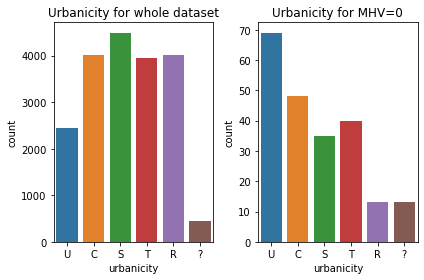

In [61]:
order = ['U','C','S','T','R','?']
fig, axs = plt.subplots(ncols=2)
sns.countplot(x=df["urbanicity"],hue_order=order, order =order, ax = axs[0]).set_title('Urbanicity for whole dataset')
sns.countplot(x=df[df.median_home_value ==0]["urbanicity"],hue_order=order, order =order, ax = axs[1]).set_title('Urbanicity for MHV=0')
plt.tight_layout()

In [62]:
df.ses.unique()

array(['?', '2', '1', '3', '4'], dtype=object)

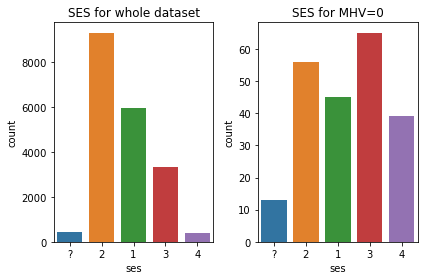

In [63]:
order = ['?', '2', '1', '3', '4']
fig, axs = plt.subplots(ncols=2)
sns.countplot(x=df["ses"],hue_order=order, order =order, ax = axs[0]).set_title('SES for whole dataset')
sns.countplot(x=df[df.median_home_value ==0]["ses"],hue_order=order, order =order, ax = axs[1]).set_title('SES for MHV=0')
plt.tight_layout()

it seems like these values tend to be more urban and in the case of ses the distribution of values is clearly skewed to the right comparing with all the data, but that doesn't tell us too much. Let's check if there is a correlation with age

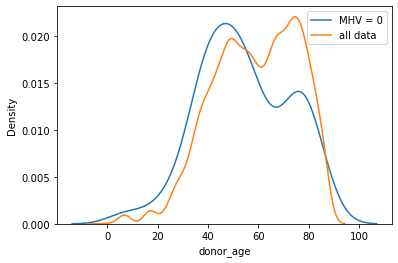

In [64]:
sns.kdeplot(df[df.median_home_value==0]['donor_age'])
sns.kdeplot(df['donor_age'])
plt.legend(labels=['MHV = 0', 'all data'])

it seems like these are younger donors. Let's what are the variables that correlate the most with median_home_value in order to impute according to that

In [65]:
df_label_encoded.corr().abs()['median_home_value'].sort_values(ascending=False)[:10]

median_home_value          1.00
per_capita_income          0.73
median_household_income    0.68
wealth_rating              0.39
ses                        0.38
income_group               0.32
urbanicity                 0.29
index                      0.26
target_d                   0.13
lifetime_avg_gift_amt      0.12
Name: median_home_value, dtype: float64

per_capita_income could be a good candidate. Let's check if it has integrity enough to base our imputation.

In [66]:
df[df.median_home_value==0]['per_capita_income']

138          0
351          0
362          0
458      37726
673      35688
         ...  
19039        0
19158        0
19305        0
19338        0
19343        0
Name: per_capita_income, Length: 218, dtype: int64

most values are zero, so not good enough. That could be a reason in fact why there is a high correlation between these is so high. Let's check the next candidate

In [67]:
df[df.median_home_value==0]['median_household_income']

138        0
351        0
362        0
458      413
673      237
        ... 
19039      0
19158      0
19305      0
19338      0
19343      0
Name: median_household_income, Length: 218, dtype: int64

the fact that almost everything is zero is suspicious. Let's count some of these values

In [68]:
df[(df.median_household_income==0) & (df.per_capita_income==0)].shape[0]

173

In [69]:
df[df.median_home_value==0].shape[0]

218

In [70]:
df[df.per_capita_income==0].shape[0]

173

there are 173 data points that have 0 on these three fields. This will help us treating these variables.

income_group also has many Nans. Imputing based on urbanicity and ses seems like a good strategy since earlier it was seen that there is a relationship between these points that that value. Also it makes sense intuitively that house value is related with socioeconomic status.

In [71]:
#set the 0 to nan
df.loc[df.median_home_value == 0,'median_home_value']=np.NaN
#group by urbanicity and ses, calculate average and use that
df['median_home_value'] = df.groupby(['ses','urbanicity'], sort=False)['median_home_value'].apply(lambda x: x.fillna(x.mean()))

<b>MEDIAN HOUSEHOLD INCOME</b> - median household income (in 100$) as determined by other input variables

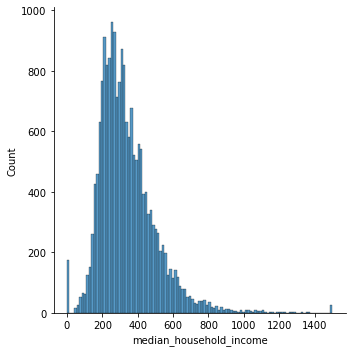

In [72]:
sns.displot(df.median_household_income)

There is a weird peak at 0. Instead of filling zero values with the mean we follow the same strategy as before

In [73]:
#set the 0 to nan
df.loc[df.median_household_income == 0,'median_household_income']=np.NaN
#group by urbanicity and ses, calculate average and use that
df['median_household_income'] = df.groupby(['ses','urbanicity'], sort=False)['median_household_income'].apply(lambda x: x.fillna(x.mean()))

<b>MONTHS SINCE FIRST GIFT</b> - number of months since the first donation from the individual to the charitable organization

<AxesSubplot:ylabel='Frequency'>

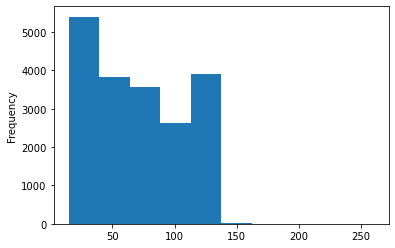

In [74]:
df_reset()
df.months_since_first_gift.plot(kind = 'hist')

Should be outlier corrected!

<b>MONTHS SINCE LAST GIFT</b> - number of months since the most recent donation from the individual to the charitable organization

<AxesSubplot:ylabel='Frequency'>

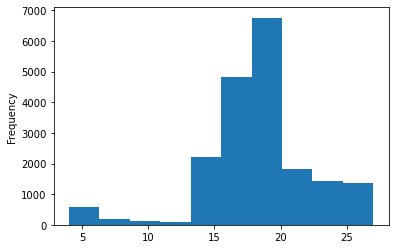

In [75]:
df.months_since_last_gift.plot(kind = 'hist')

In [76]:
df.months_since_first_gift.describe()

count    19372.00
mean        69.48
std         37.57
min         15.00
25%         33.00
50%         65.00
75%        105.00
max        260.00
Name: months_since_first_gift, dtype: float64

Should be outlier corrected!


<b>MONTHS SINCE LAST PROM RESP</b> - number of months since the individual has responded to a promotion by the charitable organization

<AxesSubplot:ylabel='Frequency'>

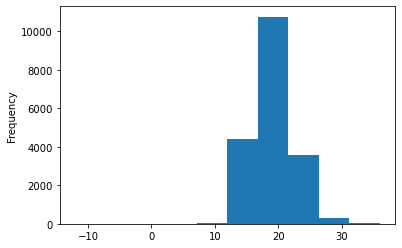

In [77]:
df.months_since_last_prom_resp.plot(kind = 'hist')

In [78]:
df.months_since_last_prom_resp.describe()

count    19126.00
mean        19.04
std          3.42
min        -12.00
25%         17.00
50%         18.00
75%         21.00
max         36.00
Name: months_since_last_prom_resp, dtype: float64

Currently a float but should be int - checking why

In [79]:
df.months_since_last_prom_resp.dtype

dtype('float64')

In [80]:
sorted(df.months_since_last_prom_resp)[:10]

[-11.0, -10.0, -10.0, -9.0, 2.0, 3.0, 6.0, 6.0, 8.0, 8.0]

There are negative values which is weird (cannot have negative time) - changing these to 0.

In [81]:
df['months_since_last_prom_resp'].values[df.months_since_last_prom_resp<1] = 0

In [82]:
sorted(df.months_since_last_prom_resp)[:10]

[0.0, 0.0, 0.0, 2.0, 3.0, 6.0, 6.0, 8.0, 8.0, 8.0]

Also checking for null values

In [83]:
df.months_since_last_prom_resp.isnull().sum()

246

246 null values - changing these for the average

In [84]:
df.months_since_last_prom_resp.fillna(value=df.months_since_last_prom_resp.mean(),inplace = True)

Now changing from float to integer

In [85]:
df.months_since_last_prom_resp = df.months_since_last_prom_resp.astype('int64')
df.months_since_last_prom_resp.dtype

dtype('int64')

<b>MONTHS SINCE ORIGIN</b> - number of months that the individual has been in the charitable organization's database

<AxesSubplot:ylabel='Frequency'>

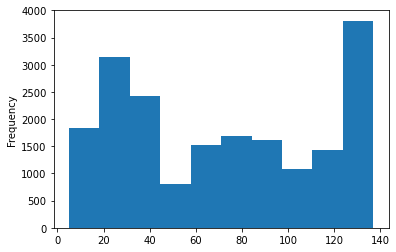

In [86]:
df.months_since_origin.plot(kind = 'hist')

In [87]:
df.months_since_origin.isnull().sum()

0

<b>MOR HIT RATE</b> - total number of known times the donor has responded to a mailed solicitation from a group other than the charitable organization

In [88]:
df.mor_hit_rate.isnull().sum()

0

C:\Users\Aldina\anaconda3\envs\py37\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mor_hit_rate', ylabel='Density'>

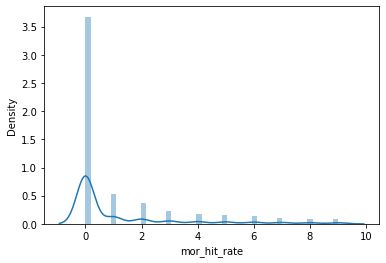

In [89]:
sns.distplot(df.mor_hit_rate[df.mor_hit_rate<10])

<b>NUMBER PROM 12</b> - number of promotions (card or other) sent to the individual by the charitable organization in the past 12 months

C:\Users\Aldina\anaconda3\envs\py37\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='number_prom_12', ylabel='Density'>

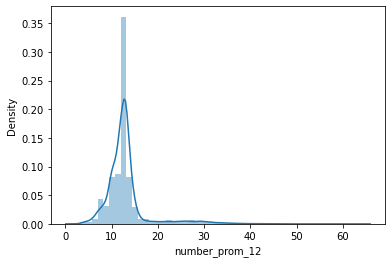

In [90]:
sns.distplot(df.number_prom_12)

In [91]:
df.number_prom_12.describe()

count    19372.00
mean        12.90
std          4.64
min          2.00
25%         11.00
50%         12.00
75%         13.00
max         64.00
Name: number_prom_12, dtype: float64

In [92]:
df.number_prom_12.isnull().sum()

0

<b>OVERLAY_SOURCE</b> - the data source against which the individual was matched: M if Metromail, P if Polk, B if both

In [93]:
df.overlay_source.value_counts()

B    8732
P    4768
N    4392
M    1480
Name: overlay_source, dtype: int64

In [94]:
# df.overlay_source = df.overlay_source.map( {'M':0,'P':1,'B':2 } ).astype('int64')


<b>PCT_ATTRIBUTE1</b> - percent of residents in the neighborhood in which the individual lives that are males and active military

In [95]:
df.pct_attribute1.isnull().sum()

0

C:\Users\Aldina\anaconda3\envs\py37\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='pct_attribute1', ylabel='Density'>

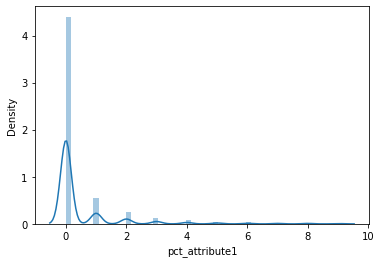

In [96]:
sns.distplot(df.pct_attribute1[df.pct_attribute1<10])

<b>PCT_ATTRIBUTE2</b> - percent of residents in the neighborhood in which the individual lives that are males and veterans

<AxesSubplot:ylabel='Frequency'>

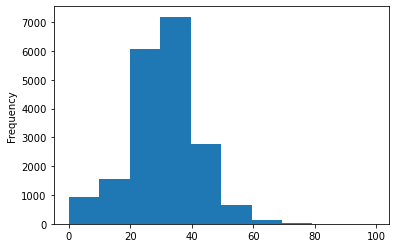

In [97]:
df.pct_attribute2.plot(kind = 'hist')

In [98]:
df.pct_attribute2.isnull().sum()

0

<b>PCT_ATTRIBUTE3</b> - percent of residents in the neighborhood in which the individual lives that are Vietnam veterans

<AxesSubplot:ylabel='Frequency'>

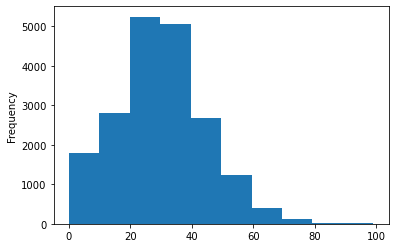

In [99]:
df.pct_attribute3.plot(kind = 'hist')

In [100]:
df.pct_attribute3.isnull().sum()

0

<b>PCT_ATTRIBUTE4</b> - percent of residents in the neighborhood in which the individual lives that are WWII veterans

<AxesSubplot:ylabel='Frequency'>

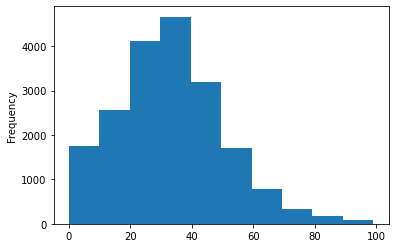

In [101]:
df.pct_attribute4.plot(kind = 'hist')

In [102]:
df.pct_attribute4.isnull().sum()

0

<b>PCT_OWNER_OCCUPIED</b> - percent of owner-occupied housing in the neighborhood in which the individual lives

<AxesSubplot:ylabel='Frequency'>

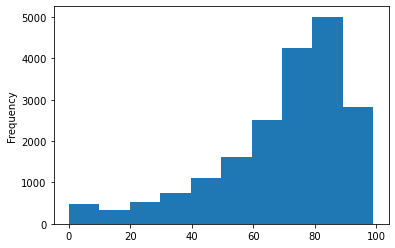

In [103]:
df.pct_owner_occupied.plot(kind = 'hist')

In [104]:
df.pct_owner_occupied.isnull().sum()

0

PCT data is clean 

#### Pep star 

it's a binary variable, with no nulls, so everything is fine

#### Per Capita Income 

C:\Users\Aldina\anaconda3\envs\py37\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='per_capita_income', ylabel='Density'>

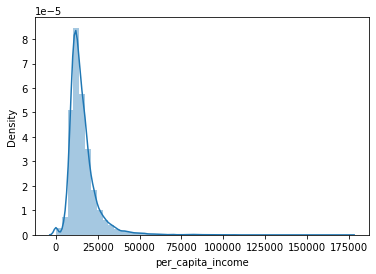

In [105]:
sns.distplot(df.per_capita_income)

It was found during the exploration of median_house_value that there are some 0 values that are probably errors in the data. Here we follow the same strategy replacing those values with the average by urbanicity and SES

In [106]:
#set the 0 to nan
df.loc[df.per_capita_income == 0,'per_capita_income']=np.NaN
#group by urbanicity and ses, calculate average and use that
df['per_capita_income'] = df.groupby(['ses','urbanicity'], sort=False)['per_capita_income'].apply(lambda x: x.fillna(x.mean()))

#### Published phone

it's a binary variable, with no nulls.

#### Recency status 96nk
description: recency status as of two years ago: A if active donor, S if star donor, N if new donor, E if inactive donor, F if first time donor, L if lapsing donor

In [107]:
df.recency_status_96nk.value_counts()

A    11918
S     4221
F     1521
N     1192
E      427
L       93
Name: recency_status_96nk, dtype: int64

Label encoding was tried but yielded worse results

#### RECENT_AVG_CARD_GIFT_AMT
average donation from the individual in response to a card solicitation from the charitable organization since four years ago

C:\Users\Aldina\anaconda3\envs\py37\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='recent_avg_card_gift_amt', ylabel='Density'>

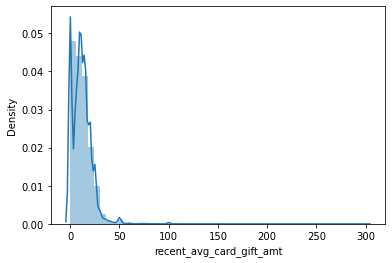

In [108]:
sns.distplot( df['recent_avg_card_gift_amt'])

Data is fine

#### RECENT_AVG_GIFT_AMT
average donation (in \\$) from the individual to the charitable organization since four years ago


C:\Users\Aldina\anaconda3\envs\py37\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='recent_avg_gift_amt', ylabel='Density'>

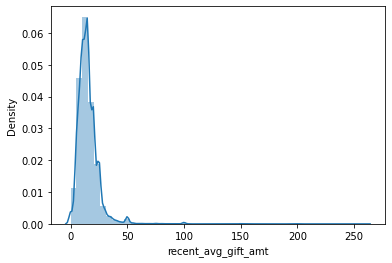

In [109]:
sns.distplot(df.recent_avg_gift_amt)

Data looks fine!

#### RECENT_CARD_RESPONSE_COUNT
number of times the individual has responded to a card solicitation from the charitable organization since four years ago

C:\Users\Aldina\anaconda3\envs\py37\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='recent_card_response_count', ylabel='Density'>

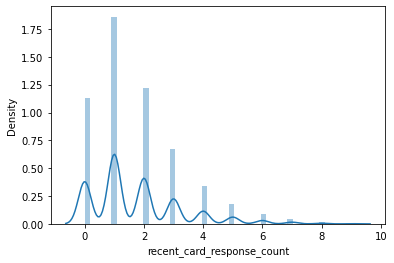

In [110]:
sns.distplot(df.recent_card_response_count)

This is fine

#### RECENT_CARD_RESPONSE_PROP
proportion of responses to the individual to the number of card solicitations from the charitable organization since four years ago


C:\Users\Aldina\anaconda3\envs\py37\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='recent_card_response_prop', ylabel='Density'>

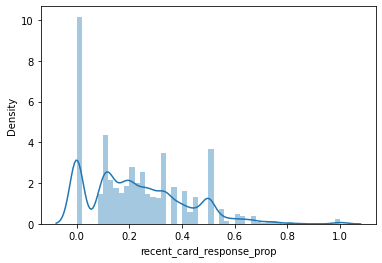

In [111]:
sns.distplot(df.recent_card_response_prop)

**note:** ideas to try
* bin variable
* could be done in categories as most is under 0.6


#### RECENT_RESPONSE_COUNT
number of times the individual has responded to a promotion (card or other) from the charitable organization since four years ago


C:\Users\Aldina\anaconda3\envs\py37\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='recent_response_count', ylabel='Density'>

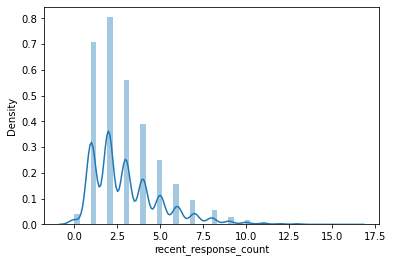

In [112]:
sns.distplot(df.recent_response_count)

**note:** ideas to try
* bin variable
* bins 0,1,2,3,4,5,6,>7?



#### RECENT_RESPONSE_PROP
proportion of responses to the individual to the number of (card or other) solicitations from the charitable organization since four years ago


C:\Users\Aldina\anaconda3\envs\py37\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='recent_response_prop', ylabel='Density'>

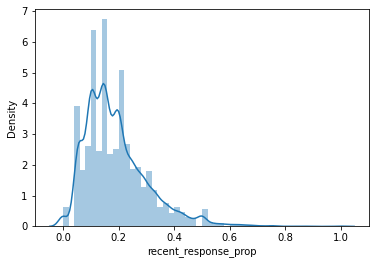

In [113]:
sns.distplot(df.recent_response_prop)

Data looks fine

#### RECENT_STAR_STATUS
1 if individual has achieved star donor status since four years ago, 0 if not


In [114]:
print(df.recent_star_status.value_counts())

0     13239
1      4289
3       346
4       320
5       205
11      183
7       140
12      122
6        88
10       86
13       84
14       61
8        54
19       27
2        26
15       26
16       18
17       15
9        15
18       12
21       10
20        4
22        2
Name: recent_star_status, dtype: int64


What to do with values above 1. Let's see whether these people have donated and whether they look like people with star status 1. Probably need clustering to check this.

In [115]:
df[df.recent_star_status > 0].sort_values(by = ['lifetime_gift_amount'])

,index,card_prom_12,cluster_code,donor_age,donor_gender,file_card_gift,frequency_status_97nk,home_owner,income_group,in_house,last_gift_amt,lifetime_avg_gift_amt,lifetime_card_prom,lifetime_gift_amount,lifetime_gift_count,lifetime_gift_range,lifetime_max_gift_amt,lifetime_min_gift_amt,lifetime_prom,median_home_value,...,pct_attribute2,pct_attribute3,pct_attribute4,pct_owner_occupied,pep_star,per_capita_income,published_phone,recency_status_96nk,recent_avg_card_gift_amt,recent_avg_gift_amt,recent_card_response_count,recent_card_response_prop,recent_response_count,recent_response_prop,recent_star_status,ses,target_b,target_d,urbanicity,wealth_rating
12267,12267,6,48,73.0,F,5,4,H,5.0,0,3.0,2.30,13,23.0,10,4.0,5.0,1.0,30,614,...,53,21,45,81,1,13969.0,0,S,3.00,2.50,4,0.50,6,0.38,1,2,0,NaN,R,NaN
11269,11269,5,41,NaN,F,8,4,U,NaN,0,1.0,1.60,16,24.0,15,4.0,5.0,1.0,43,199,...,28,26,34,62,1,6390.0,0,S,1.33,2.17,3,0.50,6,0.43,1,3,0,NaN,T,NaN
9169,9169,5,44,NaN,F,2,1,U,NaN,0,15.0,8.33,10,25.0,3,10.0,15.0,5.0,24,913,...,31,33,26,73,1,14975.0,0,S,5.00,8.33,2,0.29,3,0.19,1,2,0,NaN,R,NaN
11280,11280,6,30,NaN,F,5,4,U,NaN,0,5.0,3.57,14,25.0,7,3.0,5.0,2.0,30,280,...,33,36,26,47,1,7742.0,0,S,4.00,3.60,4,0.44,5,0.31,1,3,0,NaN,C,NaN
17003,17003,4,46,69.0,M,4,4,H,5.0,0,7.0,5.20,8,26.0,5,4.0,7.0,3.0,20,1050,...,45,22,50,76,1,11406.0,1,S,5.25,5.20,4,0.67,5,0.39,1,2,1,9.0,R,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18648,18648,6,3,47.0,M,7,1,H,6.0,1,110.0,89.44,26,1610.0,18,175.0,200.0,25.0,118,2442,...,25,47,17,56,1,38212.0,1,A,100.00,150.00,1,0.11,2,0.11,5,1,1,100.0,U,NaN
18643,18643,7,45,37.0,F,15,4,U,2.0,1,5.0,23.85,37,1622.0,68,997.0,1000.0,3.0,144,476,...,31,17,31,64,1,10581.0,0,S,7.33,7.67,3,0.30,6,0.32,1,2,1,8.0,R,2.0
1306,1306,4,.,17.0,F,17,4,U,NaN,1,133.0,63.04,29,1765.0,28,128.0,133.0,5.0,100,1375,...,0,0,0,25,1,18247.0,0,S,99.80,99.83,5,0.46,6,0.30,1,?,1,102.0,?,8.0
878,878,7,49,75.0,F,23,1,H,4.0,1,39.0,26.83,34,2200.0,82,97.0,100.0,3.0,95,448,...,31,31,22,69,1,10379.0,0,A,46.50,46.50,4,0.36,4,0.21,4,2,1,47.0,R,3.0


**What to do with all the values > 1?**

Replace with 1: When looking at the lifetime_gift_amount, they have donated a lot, so it is probable that they should have received star status. Therefore, imputing with 1



In [116]:
df['recent_star_status'].values[df.recent_star_status > 1] = 1
df.recent_star_status.value_counts()

0    13239
1     6133
Name: recent_star_status, dtype: int64

#### SES
one of 5 possible socioeconomic codes classifying the neighborhood in which the individual lives

In [117]:
df_reset()
df.ses.value_counts()

2    9284
1    5924
3    3323
?     454
4     387
Name: ses, dtype: int64

The weird '?' value correspond to the weird '.' value in the cluster code feature. Therefore, these are already taken out by that error removal.

#### URBANICITY
classification of the neighborhood in which the individual lives: U if urban, C if city, S if suburban, T if town, R if rural, ? if missing

In [118]:
df.urbanicity.value_counts()

S    4491
C    4022
R    4005
T    3944
U    2456
?     454
Name: urbanicity, dtype: int64

Same as for SES, '?' values are simply removed

#### WEALTH_RATING
one of 10 possible wealth rating groups based on a number of demographic characteristics

C:\Users\Aldina\anaconda3\envs\py37\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='wealth_rating', ylabel='Density'>

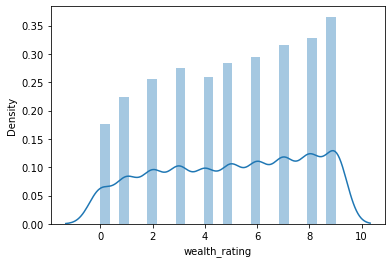

In [119]:
sns.distplot(df.wealth_rating)

In [120]:
df.wealth_rating.value_counts()

9.0    1390
8.0    1248
7.0    1199
6.0    1117
5.0    1078
3.0    1046
4.0     987
2.0     974
1.0     854
0.0     669
Name: wealth_rating, dtype: int64

Let's check correlations

In [121]:
df_label_encoded.corr().abs()['wealth_rating'].sort_values(ascending=False)[:10]

wealth_rating              1.00
median_household_income    0.60
ses                        0.53
per_capita_income          0.52
income_group               0.42
median_home_value          0.39
pct_owner_occupied         0.23
urbanicity                 0.18
home_owner                 0.14
pct_attribute3             0.12
Name: wealth_rating, dtype: float64

<AxesSubplot:xlabel='wealth_rating', ylabel='median_household_income'>

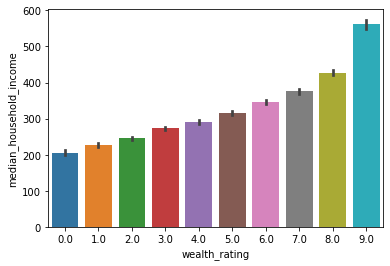

In [122]:
sns.barplot(data=df,x="wealth_rating",y="median_household_income")

the same strategy as in income_group will be adopted

In [123]:
#binning
df['median_household_bin'] = pd.qcut(df.median_household_income,9,labels=False)
#imputation
df['wealth_rating'] = df.groupby(['median_household_bin'], sort=False)['wealth_rating'].apply(lambda x: x.fillna(x.mean())).copy()
df['wealth_rating'] = df['wealth_rating'].round()
df.drop('median_household_bin',axis=1,inplace=True)

to help with the rest of the EDA we'll use the pandas profilling tool:

In [124]:
#import data and drop duplicates or irrelevant
raw_df = pd.read_csv("Donors_dataset.csv")
df = raw_df.drop(["FILE_AVG_GIFT","CONTROL_NUMBER"],axis = 1)

#reorder df columns in alphabetical order
ordered_names = list(df.columns)
ordered_names.sort()
df = df[ordered_names]
#column names to lowercase
df.columns = df.columns.str.lower()

In [125]:
#run the following to install pandas-proffiling conda install -c conda-forge pandas-profiling
from pandas_profiling import ProfileReport
profile = ProfileReport(df, title="df Report",explorative=True)

profile.to_widgets()